# False clouds in ABI static features

Clouds that do not move or evolve are more likely to be false clouds. This program overlays ABI imagery in order to see which features do not evolve with time. 

ABI data is from /mnt/grb/goes16/ on smiller2

In [2]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [3]:
date = "20220914"

root = "/home/jturner/false_low_clouds_2023/Static_Features/"+date

## Visualizing a specific time

In [5]:
data_07 = xr.open_dataset(root+'/OR_ABI-L1b-RadF-M6C07_G16_s20222570500207_e20222570509526_c20222570509568.nc')
data_14 = xr.open_dataset(root+'/OR_ABI-L1b-RadF-M6C14_G16_s20222570500207_e20222570509515_c20222570509597.nc')

In [6]:
#--- Filter to the region

#---Georges Bank
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

In [7]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [8]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [9]:
ds_07 = calc_latlon(data_07)
ds_14 = calc_latlon(data_14)

/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [10]:
lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

In [11]:
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

In [14]:
subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))
subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))

In [17]:
BTD = subset_14.Rad - subset_07.Rad
BTD

<xarray.DataArray 'Rad' (y: 206, x: 329)>
array([[ 98.014435,  98.35775 ,  98.60052 , ...,  82.90324 ,  81.10644 ,
         74.28704 ],
       [ 98.35618 ,  98.648445,  98.89278 , ...,  82.96311 ,  79.73886 ,
         73.45293 ],
       [ 99.32882 ,  99.32882 ,  99.32882 , ...,  79.84254 ,  74.69122 ,
         70.192696],
       ...,
       [ 71.56709 ,  71.905716,  72.04325 , ..., 106.450294, 106.30339 ,
        106.31747 ],
       [ 75.61081 ,  77.76188 ,  76.91425 , ..., 106.4055  , 106.07001 ,
        104.378456],
       [ 72.106255,  67.980194,  71.8046  , ..., 106.83529 , 106.450294,
        106.01895 ]], dtype=float32)
Coordinates:
  * y        (y) float32 0.11387599 0.113819994 ... 0.102451995 0.102396
  * x        (x) float32 0.0076440126 0.007700011 ... 0.025956005 0.026012003
    y_image  float32 0.0
    x_image  float32 0.0
    lat      (y, x) float32 42.472664 42.472725 42.473076 ... 37.0087 37.009174
    lon      (y, x) float32 -71.49289 -71.467155 ... -64.03719 -64.01304

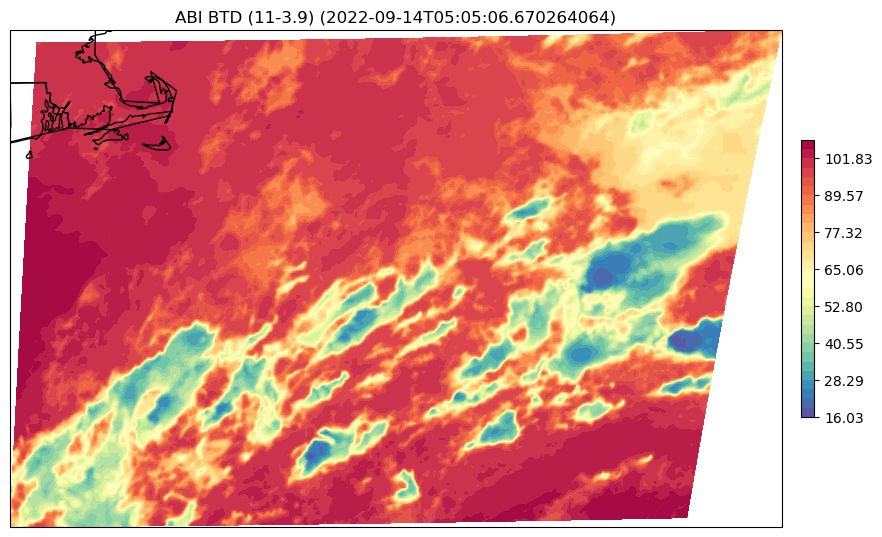

In [26]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)

c=ax.contourf(BTD.lon, BTD.lat, BTD, cmap=cmap, levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI BTD (11-3.9) ('+str(subset_07.t.values)+')')
clb.set_label('')

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

## Combining the range of times

In [32]:
#--- Initialize the 2D summed array with zeroes

subset_Rad_tot_07 = [ [0]*len(BTD[0]) for i in range(len(BTD))]
subset_Rad_tot_14 = [ [0]*len(BTD[0]) for i in range(len(BTD))]

#--- For each of the files in dir, crop and sum the radiances

print('Collecting Band 07')

for filename in os.listdir(root):
    
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C07':
    
        data_07 = xr.open_dataset(root+'/'+filename)

        ds_07 = calc_latlon(data_07)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

        subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))

        subset_Rad_tot_07 = subset_Rad_tot_07+subset_07.Rad
    
print('Collecting Band 14')

for filename in os.listdir(root):
    
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C14':
    
        data_14 = xr.open_dataset(root+'/'+filename)

        ds_14 = calc_latlon(data_14)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_14, lats, lons)

        subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))

        subset_Rad_tot_14 = subset_Rad_tot_14+subset_14.Rad

/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encount

/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_24995/1456945755.py:20: RuntimeWarning: invalid value encount

In [33]:
BTD = subset_Rad_tot_14 - subset_Rad_tot_07

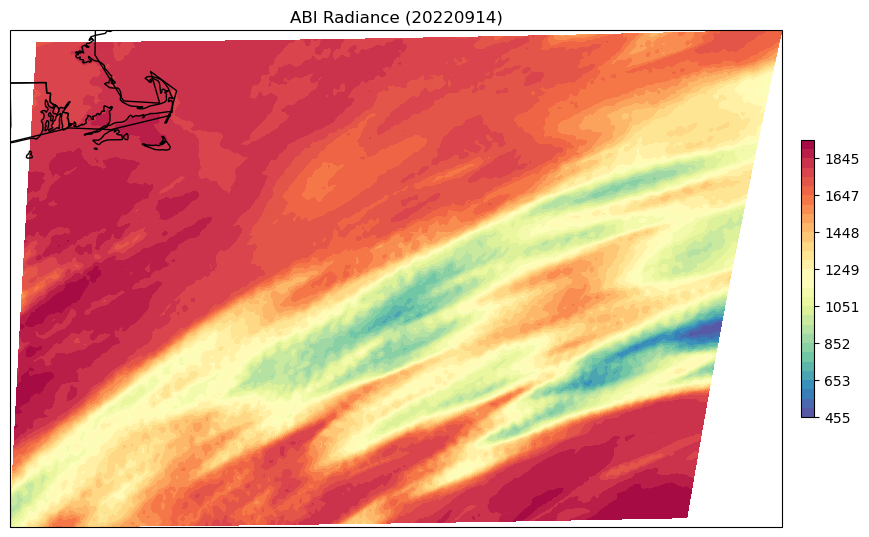

In [35]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)

c=ax.contourf(BTD.lon, BTD.lat, BTD, cmap=cmap, levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('')

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)